# February, 12th 2021

**Motivation**: Simple analysis on data. Learn how it is structured, come up with clarification questions.<br>
**Results**:  In this document I only focus on BOLD signals, and discuss Ca on the next page.

In [1]:
# HIDE CODE


import re
import os
import numpy as np
import pandas as pd
import nibabel as nib
from os.path import join as pjoin
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## About dataset

First, I am copying email from Eve below to discuss different things.  Down below I will summarize things I think I understood, and discuss the parts I didn't fully understand.



### Email from Eve
---

#### Data sets

During our conversation, we touched on four data sets. 

(1) The published data from the Nature Methods paper. This data set includes N=6 mice imaged acutely (immediately after surgery to optically expose the skull) at a single time point. Each imaging session is composed of n=9 runs that are 10-minutes in length (a total of 90 minutes of simultaneous fMRI/calcium imaging data). During 4/9 runs we presented unilateral hind-limb stimulation. The remaining 5/9 runs are rest-runs. The stimuli are short (5 seconds in duration) and presented sparsely - once every minute in a 5:55 second ON:OFF cycle. All data are collected under low-dose isoflurane anesthesia. 

(2) Unpublished longitudinal data. This data set includes N=10 mice imaged chronically. Mice underwent surgery (to optically expose the skull) 7 days before the first imaging session. Mice are imaged at three time points with a minimum of 7 days between each imaging sessions. During each imaging session, we collect n=7 runs that are 10-minutes in length (a total of 70 minutes of simultaneous fMRI/calcium imaging data at each of three different time points or 210 minutes of data per mouse). During 3/7 runs we present unilateral visual stimulation. The remaining 4/7 runs are rest-runs. Again, the stimuli are short (5 seconds in duration) and presented sparsely - once every minute in a 5:55 second ON:OFF cycle. All data are collected under the same low-dose isoflurane anesthesia. 

(3) Unpublished 'state' data. This data set includes N=9 mice. Six of these animals are shared between this experiment and the one above (2 - longitudinal data). After the third and final simultaneous fMRI/calcium imaging session, these N=6 underwent an additional calcium-only out-of-scanner imaging session. These data are collected using 'traditional' or commercially available calcium imaging hardware. During this experiment, we collected data under anesthesia (to match the in-scanner condition) and under the awake condition. The additional N=3 mice in this data set underwent one in-scanner simultaneous fMRI/calcium imaging session, and one out-of-scanner calcium-only anesthetized/awake imaging session. The in-scanner data are collected following the same protocol as described above (2 - longitudinal data). I will need to review the out-of-scanner data to provide you with a good summary.  

All the animals described in data sets 1, 2 and 3 have excitatory neurons labeled with a calcium indicator. 

(4) Unpublished multi-cell data. These experiments are the same as those described above for data set 2 but include animals with different cell-type labels. Moving forward we can discuss these data further. Overall, due to the sparseness of these cell populations the calcium signal is dimmer and more difficult to analyze. It makes the most sense to begin with the stronger excitatory neural signal. 

#### Data registration and preprocessing: 

Most of this is described in the Nature Methods manuscript. However, I think it's useful to go over the key points here.  Also, since submitting this manuscript, we've made a number of improvements to the pipeline. 
 
**MRI Data.** All fMRI data is collected at 1Hz. The anatomical MR images that are acquired at each imaging session include: an isotropic (0.2mm) anatomical image of the whole brain (including cerebellum and olfactory bulb), a high in-plane resolution (0.1x0.1x0.4mm) anatomical image that matches the prescription of the fMRI data (0.4mm isotropic), and a time-of-flight angiogram. The angiogram is used to register the MR to the calcium data. The isotropic whole-brain anatomical image is used to generate a non-linear transformation to a common space (which we've created). The fMRI data are registered to the high in-plane resolution anatomical image, and the high in-plane resolution anatomical image is registered to the isotropic anatomical whole-brain image. By concatenating these two transforms, we move the fMRI data into the 'individual mouse anatomical space' i.e. the native space of the isotropic anatomical whole-brain image. These fMRI data can then be moved into the common space using the non-linear transformation derived from registering the isotropic anatomical image to our reference space. This is a bit hard to follow - I'm happy to explain in more detail (and to provide pictures) if you have any questions. The take-home message is that we have three spaces where our fMRI data can reside: 

(A) Native fMRI space (no transformations)
(B) Individual mouse anatomical space where the fMRI data have been registered to an isotropic anatomical image from the same mouse (collected during the same imaging session) [linear transformations only]
(C) a common reference space (shared between mice/sessions) [follows a non-linear transformation]. 


**Calcium data.** We acquire two wavelengths (each at 20Hz). The first (cyan) is calcium-indicator sensitive, the second (violet) is calcium-indicator insensitive. Signal in the violet channel can result from autofluorescence and hemodynamic changes. Thus, the violet serves as a baseline measurement. The cyan and violet frames are interleaved throughout the acquisition. As part of the preprocessing of these data, the violet frames are regressed from the cyan frames. This leaves an effective 10Hz measurement of calcium-indicator sensitive fluorescence. To register the calcium data to the fMRI data we use the MR-angiogram. The calcium data can reside in any of the three aforementioned spaces. 

Our preprocessing is conducted using an in-house built platform (which includes a bunch of tools designed to deal with the multi-modal data). The platform and tools are freely available online if you want to check them out (https://bioimagesuiteweb.github.io/webapp/). The code for BioImage Suite is written in C++. We also implement some preprocessing in Python (notably the preprocessing of the calcium data), and MATLAB. Happy to discuss further. 


##### Preprocessing the fMRI data:

(1) Motion correction (all runs in one session to the middle slice of the first run) - six parameters - this is done in (A) native fMRI space

(2) Using linear registration, move fMRI data to (B) individual mouse anatomical space (interpolate resolution from 0.4mm to 0.2mm isotropic) 

(3) Apply a brain mask* to the fMRI data - remaining steps applied within the mask

(4) Regress 6 motion parameters (from step one)

(5) Bandpass filter [0.008-0.2Hz] and global signal regression

(6) Transform data to (C) the common reference space

 

*Our brain masks are derived using an automated deep learning approach. This is (in-part) why we haven't included a ventricular mask (yet). 


##### Preprocessing the calcium data:

(1) Separation of the cyan and violet frames

(2) Data are smoothed from 25x25um to 50x50um (median filter, kernel size 4)

(3) Motion correction (all runs in one session to the middle slice of the first run) - two parameters - this frame is used for registration to the MRI data
- Motion correction is run on the cyan and violet wavelengths independently and applied to each
- Motion parameters are computed on heavily smoothed data (size 16 kernel) but applied to less smoothed data from after step 2

(4) Photobleaching correction (done on each wavelength), computed within mask*

(5) Regress violet from cyan, computed within mask

(6) Transform data to (C) the common reference space

*These masks are drawn in the angiogram MRI space and transformed into the optical space using a linear registration. 

#### Where we're at:
Each of the four aforementioned data sets are at a different point in the preprocessing pipeline.
From our conversation, it seems to me that you're most interested in data after the preprocessing described above has been applied, and the multi-modal data have been moved to a common reference space (C). 
This is why I've included all the details above, just in case you can foresee a problem with the analyses you plan to perform, or if something comes up unexpectedly. 

(1) The published data from the Nature Methods paper. These data are currently only in (B) individual mouse anatomical space. For the methods paper, we never moved the data to a common reference space (C). Further, we've made a number of improvements to the calcium preprocessing pipeline since analyzing these data. It's on my to-do list to move these data to common space, and to re-run the preprocessing using our improved protocol. I hope to get to this early in the New Year. 

(2) Unpublished longitudinal data. We are in the final stages of preprocessing these data using the new pipeline. The fMRI data preprocessing is complete, and the data have been transposed into the common reference space (C). The last steps of the calcium preprocessing (using the newest pipeline) are currently running. I expect it to be complete within the next 7 days. After we've had a chance to double check that everything has turned out as expected, we could share these data.

(3) Unpublished 'state' data. The simultaneous fMRI/calcium imaging data from 6/9 of these mice are shared with data set (2). Thus, these data would be ready at the same time. The additional N=3 simultaneous imaging sessions have not yet been analyzed. Further, we have not analyzed the out-of-scanner calcium imaging data. It is my hope that we will be able to prioritize analyzing the remaining components of this data set in late January. However, if you are particularly interested in these data please let me know and we can see if there is a way to expedite the process. 

It seems to me that it makes the most sense for us to share data set (2) with you when it reaches the end of the preprocessing pipeline in a couple weeks. Please let me know if you've come to a different conclusion. I can also keep you apprised of where we're at with the other data I've described. 

#### End of email.
---


### My summary

Here is what I understand form this email, the Nature Methods paper, and also looking at the dataset shared on Drive.

#### Dataset on Drive

There are:

- $N=10$ mice
- 3 sessions each
- 7 runs per session 
- 10 mins of simultaneous ca and fmri data in all the runs and sessions

This means we have 21 runs total, or 210 minutes of data per mouse.  Roughly, half of the data is *rest* runs, and the other half is *LED* stimulation.  It seems like the dataset currently is in **individual space** format, which is **space (B)** as described above in the emial.

#### Correspondence between data modalities

There are 3 anatomical MR images used for different purposes:

    i) isotropic (0.2mm) anatomical image of the whole brain (including cerebellum and olfactory bulb),
    ii) high in-plane resolution (0.1x0.1x0.4mm) anatomical image,
        this matches the prescription of the fMRI data (0.4mm isotropic),
    iii) time-of-flight angiogram,
    
These images are used for different things: The fMRI data are registered to (ii), and (ii) is registered to (i).  Therefore, by concatenating these two transformaitons they move the fMRI data into the *individual mouse anatomical space* i.e. the native space of (i).  Also, (i) is used to generate a non-linear transformation to a common space (shared among animals, this would be **space (C)**).  Finally, (iii) is used to register the MR to the calcium data.

I still don't know the full details.  Will have to ask Dave about details.  For example, fMRI data are currently in **xyzt format**:

- xy: 64 x 64 planes across the brain
- z: times a depth direction which I suspect corresponds to anterior -> posterior, and
- t: is 600 frames, since each run is 10 mins long and f = 1 Hz.

In contrast, Ca data is in **xyt** format:

- xy: 256 x 250 corresponds to cortex surface
- t: is 6000 frames, because Ca data has an effective rate of f = 10 Hz.

I still don't know how to precisely interpret these dimensions and how to related fMRI to Ca data in an exact way.  Fig 2 from the paper is helpful, which I'm embedding here:

![Drag Racing](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41592-020-00984-6/MediaObjects/41592_2020_984_Fig2_HTML.png)


#### Processing the data

It is great to be aware of the preprocessing details, however I still have a few questions about the details.  I will discuss this more later on.


### Very simple analysis

Ok let's plot some of the data and see how it looks like.  In this document I will only look at some fMRI data, and do Ca next in a separate document.

In [2]:
# HIDE CODE


data_dir = '/home/hadi/Documents/Ca-fMRI'
p = re.compile("part-\d")

ca_tmp = {}
ca = {}
bold = {}


animals = ['sub-SLC02', 'sub-SLC08', 'sub-SLC10']

for file_name in sorted(os.listdir(data_dir)):
    meta = file_name.split('_')
    sub = next(filter(lambda x: 'sub' in x, meta))
    ses = next(filter(lambda x: 'ses' in x, meta))
    run = next(filter(lambda x: 'run' in x, meta))
    task = next(filter(lambda x: 'task' in x, meta))
    key = '_'.join([sub, ses, run, task])
    
    skip = True
    for item in animals:
        if item in file_name:
            skip = False
    if skip:
        continue
    
    with open(pjoin(data_dir, file_name)) as f:
        data = nib.load(f.name).get_fdata()
    
    if 'bold' in file_name:
        bold[key] = data
    else:
        key += ':' + p.search(file_name).group(0)
        ca_tmp[key] = data

for k in bold:
    _ca_data = []
    for i in range(1, 4):
        _ca_data.append(ca_tmp[k + ':part-{:d}'.format(i)])
    ca[k] = np.concatenate(_ca_data, axis=-1)
    
ca = {k: ca[k] for k in sorted(ca)}
bold = {k: bold[k] for k in sorted(bold)}

for k, v in bold.items():
    print("Meta:  {:s}\t\tData shape: {}".format(k, v.shape))

Meta:  sub-SLC02_ses-1_run-5_task-rest		Data shape: (64, 64, 78, 600)
Meta:  sub-SLC08_ses-2_run-1_task-rest		Data shape: (64, 64, 78, 600)
Meta:  sub-SLC10_ses-1_run-4_task-led		Data shape: (64, 64, 78, 600)


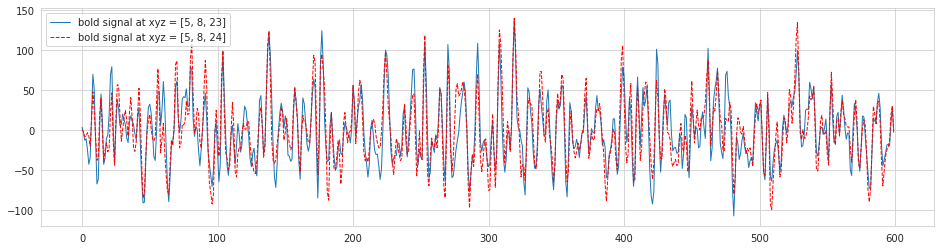

In [3]:
# HIDE CODE


key = 'sub-SLC08_ses-2_run-1_task-rest'

plt.figure(figsize=(16, 4))
plt.plot(bold[key][5, 8, 23], lw=1, label='bold signal at xyz = [5, 8, 23]')
plt.plot(bold[key][5, 8, 24], 'r--', lw=1, label='bold signal at xyz = [5, 8, 24]')

plt.legend()
plt.show()

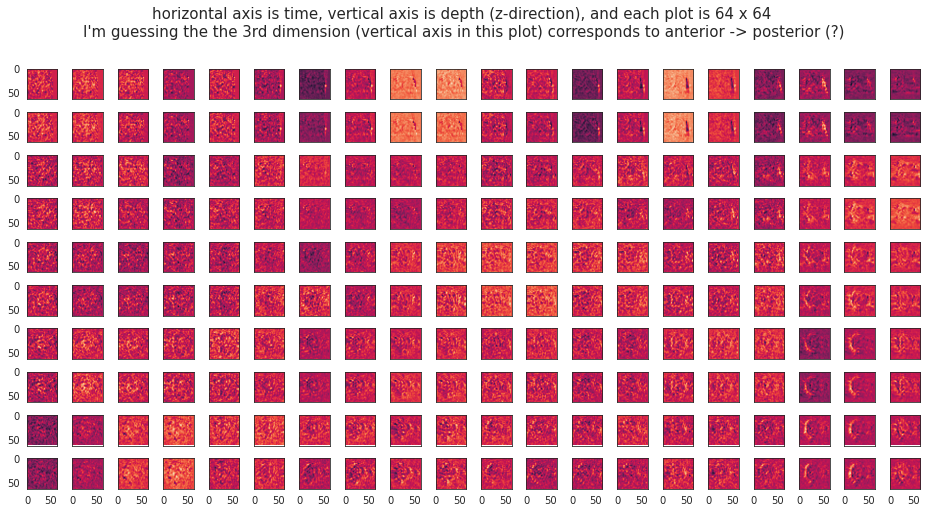

In [4]:
# HIDE CODE


sns.set_style('white')
fig, axes = plt.subplots(10, 20, figsize=(13, 7), sharex='all', sharey='all')

for i, t in enumerate(range(100, 120, 1)):
    for j, frame in enumerate(range(13, 23)):
        axes[j, i].imshow(bold[key][..., frame, t])

msg = "horizontal axis is time, vertical axis is depth (z-direction), and each plot is 64 x 64 \n"
msg += "I'm guessing the the 3rd dimension (vertical axis in this plot) corresponds to anterior -> posterior (?)"
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

In [5]:
# HIDE CODE


from scipy.stats import pearsonr

source = (29, 30, 31)
corrs = np.zeros(bold[key].shape[:-1])

for i in tqdm(range(bold[key].shape[0])):
    for j in range(bold[key].shape[1]):
        for k in range(bold[key].shape[2]):
            r, p = pearsonr(bold[key][i, j, k, :],
                            bold[key][source[0], source[1], source[2], :])
            if not np.isnan(r):
                corrs[i, j, k] = r

/home/hadi/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


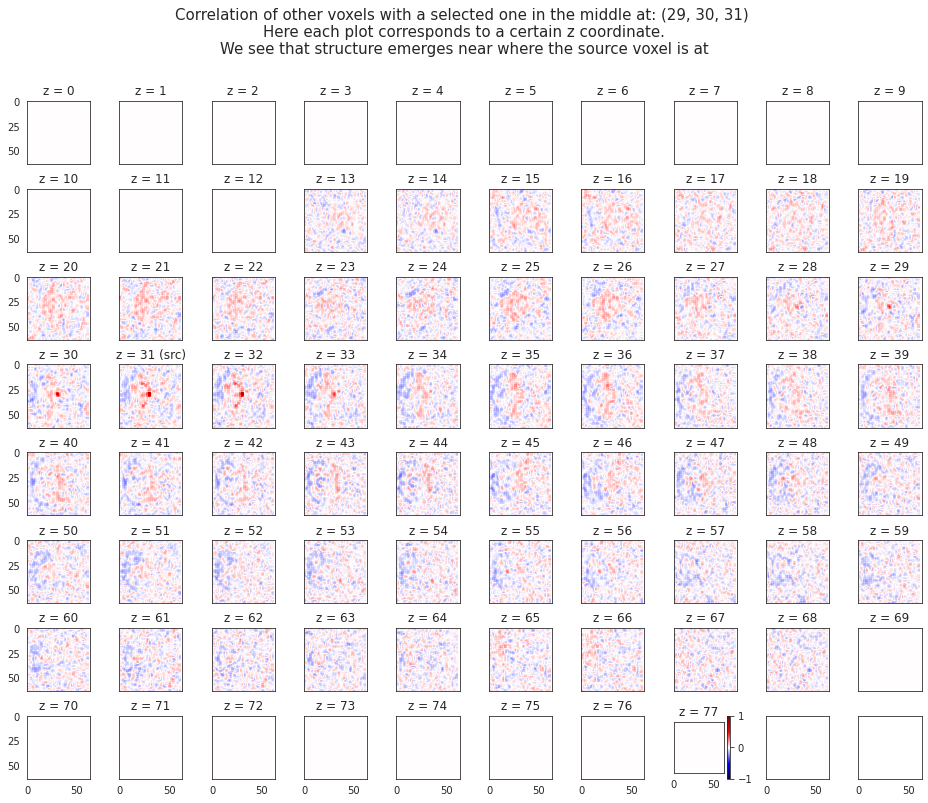

In [6]:
# HIDE CODE


sns.set_style('white')
ncols = 10
nrows = int(np.ceil(bold[key].shape[2] / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 11), sharex='all', sharey='all')

for idx in range(bold[key].shape[2]):
    i, j = idx // ncols, idx % ncols
    im = axes[i, j].imshow(corrs[..., idx], vmin=-1, vmax=1, cmap='seismic')
    axes[i, j].set_title("z = {:d} (src)".format(idx) if source[2] == idx else 'z = {:d}'.format(idx))
    
plt.colorbar(im, ax=axes[i, j])

msg = "Correlation of other voxels with a selected one in the middle at: {} \n"
msg += "Here each plot corresponds to a certain z coordinate.\n"
msg += "We see that structure emerges near where the source voxel is at"
fig.suptitle(msg.format(source), fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

We see that a lot of these frames are empty, so we need to remove them in processing.  Note that at z = 29 (src) we hace a sharp +1 correlation at the center (x, y) = (30, 31) which is where the source voxel was at.

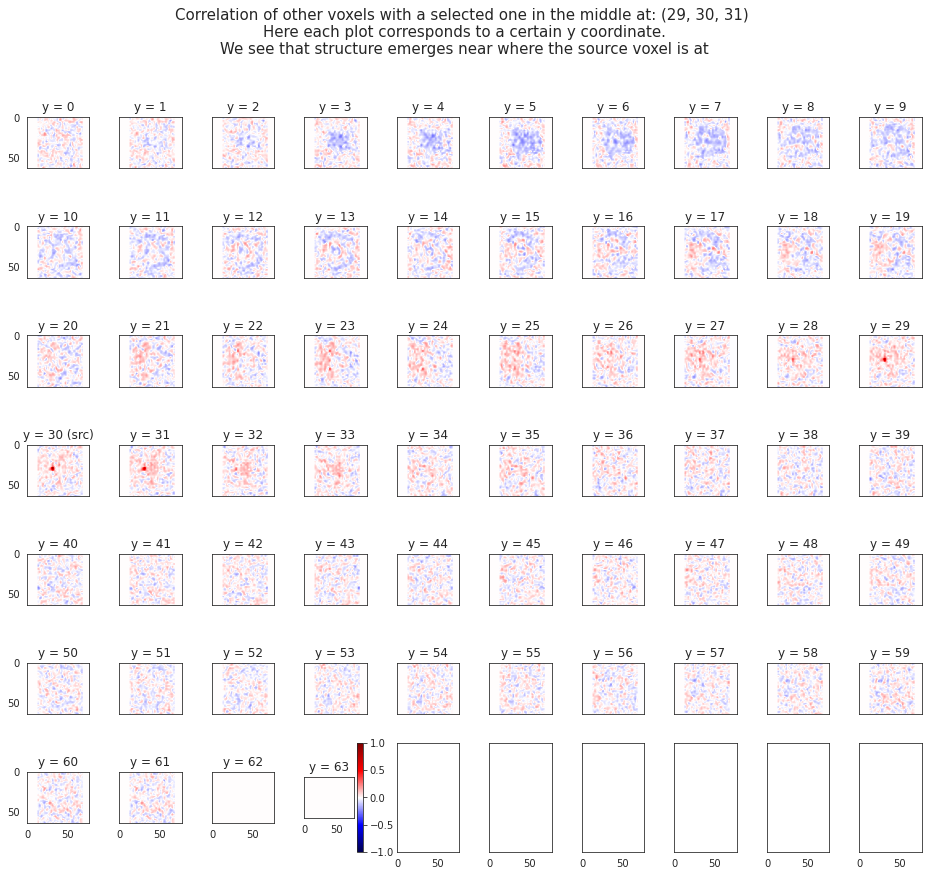

In [7]:
# HIDE CODE


sns.set_style('white')
ncols = 10
nrows = int(np.ceil(bold[key].shape[1] / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 12), sharex='all', sharey='all')

for idx in range(bold[key].shape[1]):
    i, j = idx // ncols, idx % ncols
    im = axes[i, j].imshow(corrs[:, idx, :], vmin=-1, vmax=1, cmap='seismic')
    axes[i, j].set_title("y = {:d} (src)".format(idx) if source[1] == idx else 'y = {:d}'.format(idx))
    
plt.colorbar(im, ax=axes[i, j])

msg = "Correlation of other voxels with a selected one in the middle at: {} \n"
msg += "Here each plot corresponds to a certain y coordinate.\n"
msg += "We see that structure emerges near where the source voxel is at"
fig.suptitle(msg.format(source), fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

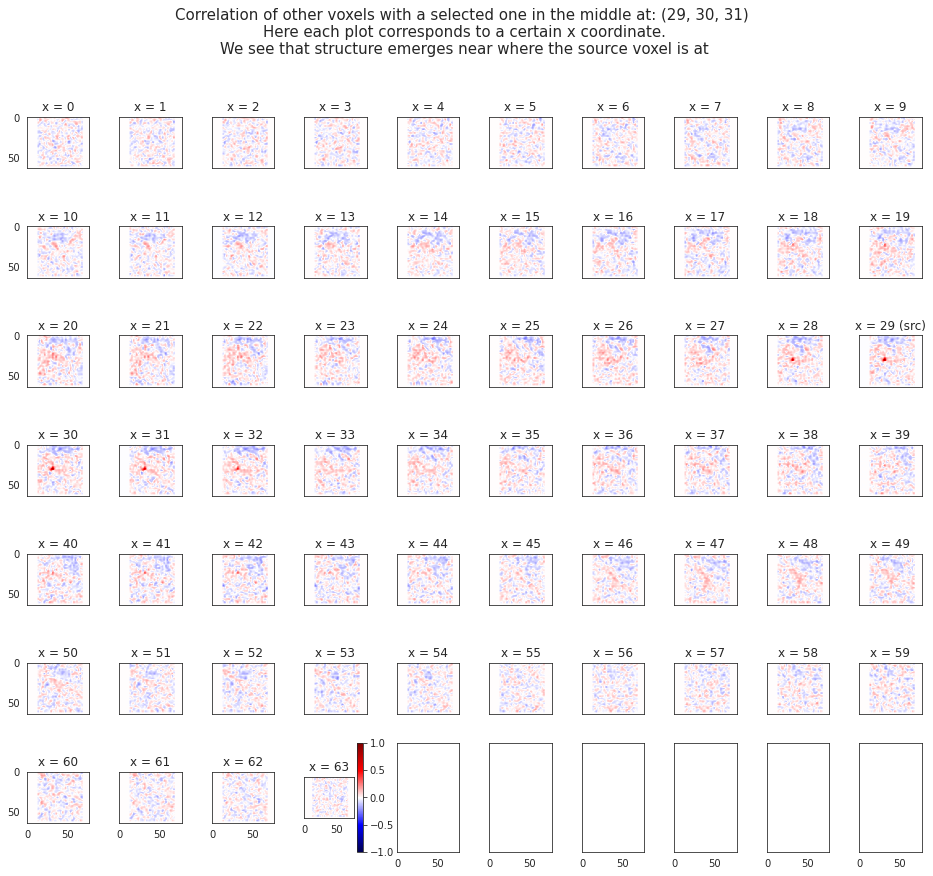

In [8]:
# HIDE CODE


sns.set_style('white')
ncols = 10
nrows = int(np.ceil(bold[key].shape[0] / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 12), sharex='all', sharey='all')

for idx in range(bold[key].shape[0]):
    i, j = idx // ncols, idx % ncols
    im = axes[i, j].imshow(corrs[idx, ...], vmin=-1, vmax=1, cmap='seismic')
    axes[i, j].set_title("x = {:d} (src)".format(idx) if source[0] == idx else 'x = {:d}'.format(idx))
    
plt.colorbar(im, ax=axes[i, j])

msg = "Correlation of other voxels with a selected one in the middle at: {} \n"
msg += "Here each plot corresponds to a certain x coordinate.\n"
msg += "We see that structure emerges near where the source voxel is at"
fig.suptitle(msg.format(source), fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

## Discussion

There are things that I still don't understand about standard practice in working with BOLD data.

- How to interpret multiple dimensions in the data?  Does z dimention correspond to anterior <-> posterior?
- Do we care about subcortical data, or only cortex? Since Ca signal is only from cortex.
- How to map to cortical surface?  In Najafi16 it is mentioned that "cortical data were mapped to the surface (using the Conte69, 32k standard mesh)".  I think this is supposed to be part of the preprocessing step, when they map both Ca and BOLD signals to a common space.  And as far as I could tell, this mapping would be still linear, because the nonlinear one would be about a common space among subjects.
- How to define ROIs.  In Najafi16 it is mentiond that "cortical regions of interest (ROIs) were deﬁned to cover the cortex, yet be small enough to minimize the mixing of signals from adjacent but (potentially) functionally heterogeneous regions. k-Means (with “city block” or L 1 distance; 1000 iterations; Duda et al., 2012) was used to cluster each cortical hemisphere into 500 target regions based on their xyz coordinates. Thus, ROIs were deﬁned based on their spatial coordinates on the cortical mesh, not functional data". This makes sense, because ROIs should be defined irrespective of functional considerations(?).
- I still don't understand how k-means is used to define ROIs.  Is it just each voxel has a 3-d vector for its position, and k-means is applied to these 3-d position vectors?  After mapping data to a surface mesh? In that case it would be a 2d position vector?
- Is this statement correct: "ROIs are defined based on coordinate positions, parcellation on the other hand is defined either anatomically, or functionally, correct?  For example, one can use Allen Atlas to parcellate many ROIs to a larger region. One can also use pearson correlation + a community detection algorithm to achieve functional parcellation.  And sometiems we don't want to assign strict binary memebeship values to ROIs, therefore, we use Bayesian mixed-membership algorithms to get a fluid parcellation just like Njafi16."

I think discussing these in a meeting would greatly help me understand the fMRI data strcutures and processing steps much better.